# 时间序列——基金预测模型
**姓名：邹子涵**  
**学号：202020085400139**
## 一、爬取数据集
基金数据选择：[信达澳银新能源产业股票(001410)](http://finance.sina.com.cn/fund/quotes/001410/bc.shtml)

In [1]:
import requests
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling as ppf

from pandas.plotting import autocorrelation_plot

import warnings
warnings.filterwarnings('ignore')

抓包，爬取数据集，数据来源：[**新浪财经**](https://finance.sina.com.cn/)  
  
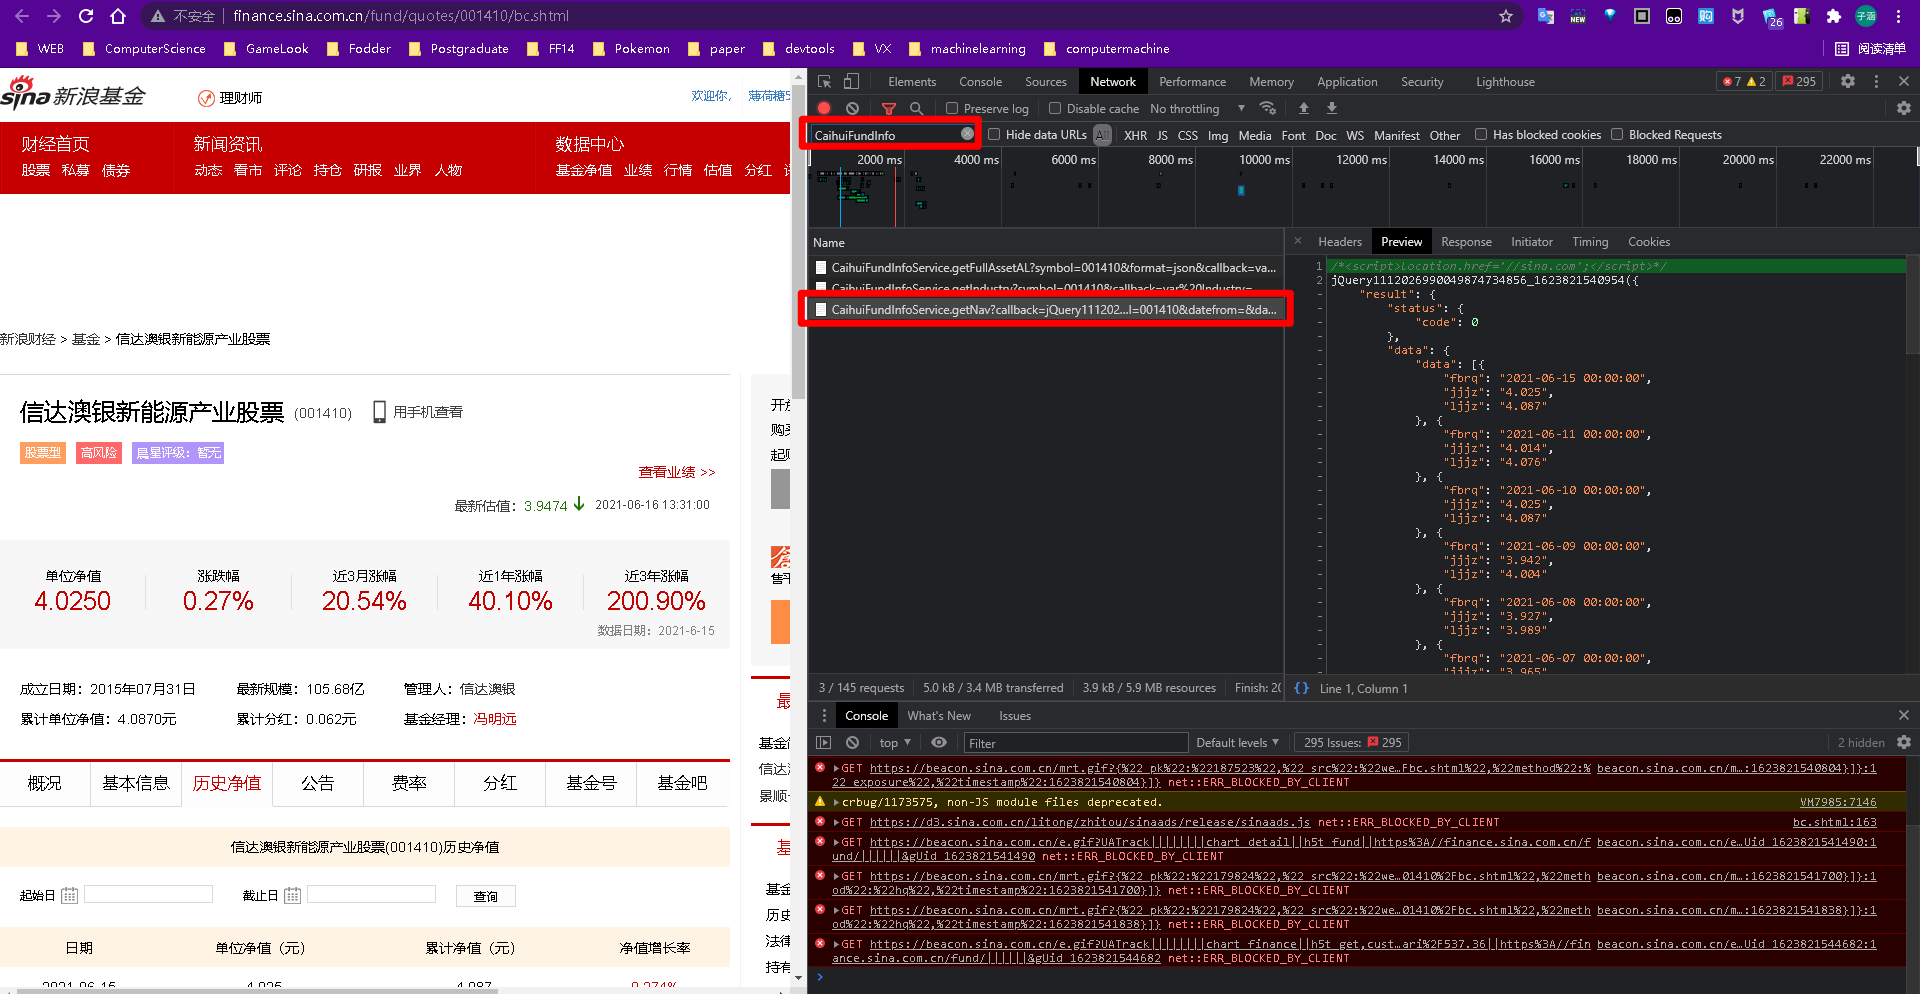  
  
右键复制获得数据来源URL，page参数为数据页数

In [2]:
pre_url = "https://stock.finance.sina.com.cn/fundInfo/api/openapi.php/CaihuiFundInfoService.getNav?callback=jQuery11120483384992229027_1623820532057&symbol=001410&datefrom=&dateto=&page="
max_page = 70

data = []

for i in range(max_page):
    url = pre_url + str(i+1)
    html = requests.get(url).content
    data = data + re.findall(u'\{"fbrq.*?"\}',html.decode('utf-8'))

数据展示（前十条）

In [3]:
data[:10]

['{"fbrq":"2021-07-19 00:00:00","jjjz":"4.781","ljjz":"4.843"}',
 '{"fbrq":"2021-07-16 00:00:00","jjjz":"4.826","ljjz":"4.888"}',
 '{"fbrq":"2021-07-15 00:00:00","jjjz":"4.894","ljjz":"4.956"}',
 '{"fbrq":"2021-07-14 00:00:00","jjjz":"4.835","ljjz":"4.897"}',
 '{"fbrq":"2021-07-13 00:00:00","jjjz":"4.953","ljjz":"5.015"}',
 '{"fbrq":"2021-07-12 00:00:00","jjjz":"5.012","ljjz":"5.074"}',
 '{"fbrq":"2021-07-09 00:00:00","jjjz":"4.847","ljjz":"4.909"}',
 '{"fbrq":"2021-07-08 00:00:00","jjjz":"4.834","ljjz":"4.896"}',
 '{"fbrq":"2021-07-07 00:00:00","jjjz":"4.728","ljjz":"4.79"}',
 '{"fbrq":"2021-07-06 00:00:00","jjjz":"4.562","ljjz":"4.624"}']

爬取的数据字段为**日期，单位净值，累计净值**  
  
初始化存储列表

In [4]:
Time = ['']*len(data)
JJJZ = ['']*len(data)
LJJZ = ['']*len(data)

for i in range(len(data)):
    dataArray = data[i].split('"')
    Time[i] = pd.to_datetime(dataArray[3][0:10])
    JJJZ[i] = float(dataArray[7][0:10])
    LJJZ[i] = float(dataArray[11][0:10])

In [5]:
df = pd.DataFrame({'Date':Time,'JJJZ':JJJZ,'LJJZ':LJJZ})
# df = df.drop_duplicates()
# df = df.sort_values(by='Date')
# df.index = range(len(df))
# df['weekday'] = df['Date'].dt.weekday
# df.iloc[::-1]
df

,Date,JJJZ,LJJZ
0,2021-07-19,4.781,4.843
1,2021-07-16,4.826,4.888
2,2021-07-15,4.894,4.956
3,2021-07-14,4.835,4.897
4,2021-07-13,4.953,5.015
...,...,...,...
1465,2015-11-03,1.025,1.025
1466,2015-11-02,1.030,1.030
1467,2015-10-30,1.042,1.042
1468,2015-10-29,1.038,1.038


<AxesSubplot:xlabel='Date'>

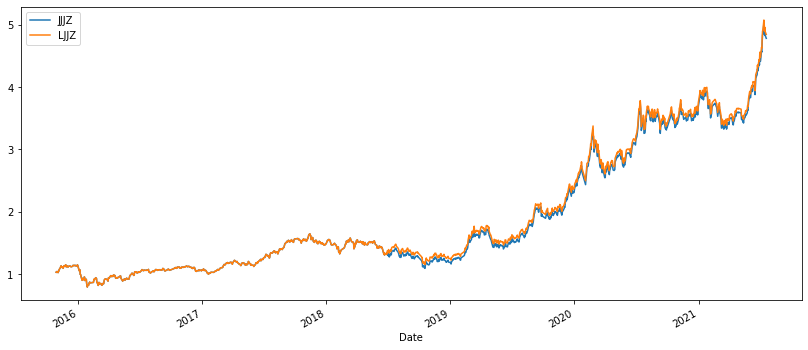

In [6]:
dfsort = df.sort_values(by='Date').set_index('Date')
plt.style.use({'figure.figsize':(14, 6)})
dfsort.plot()

In [7]:
dfsort

,JJJZ,LJJZ
Date,,
2015-10-28,1.031,1.031
2015-10-29,1.038,1.038
2015-10-30,1.042,1.042
2015-11-02,1.030,1.030
2015-11-03,1.025,1.025
...,...,...
2021-07-13,4.953,5.015
2021-07-14,4.835,4.897
2021-07-15,4.894,4.956


## 二、探索数据集
**查看数据统计特征**

In [8]:
df.describe()

,JJJZ,LJJZ
count,1470.000000,1470.000000
mean,1.879646,1.912671
std,0.973845,0.993976
min,0.793000,0.793000
25%,1.152000,1.157250
50%,1.483000,1.501500
75%,2.649000,2.711000
max,5.012000,5.074000


**探索性数据分析-EDA。**

In [9]:
report = ppf.ProfileReport(df)
# report

从探索结果中可以看到数据**无缺失值**，爬取数据的时间区间为**2015-09-18至今**(双休、节假日除外)。  
将探索结果导出为html文件

In [10]:
report.to_file('report.html')

Summarize dataset:   0%|          | 0/16 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

**绘制每年的基金发展趋势图**

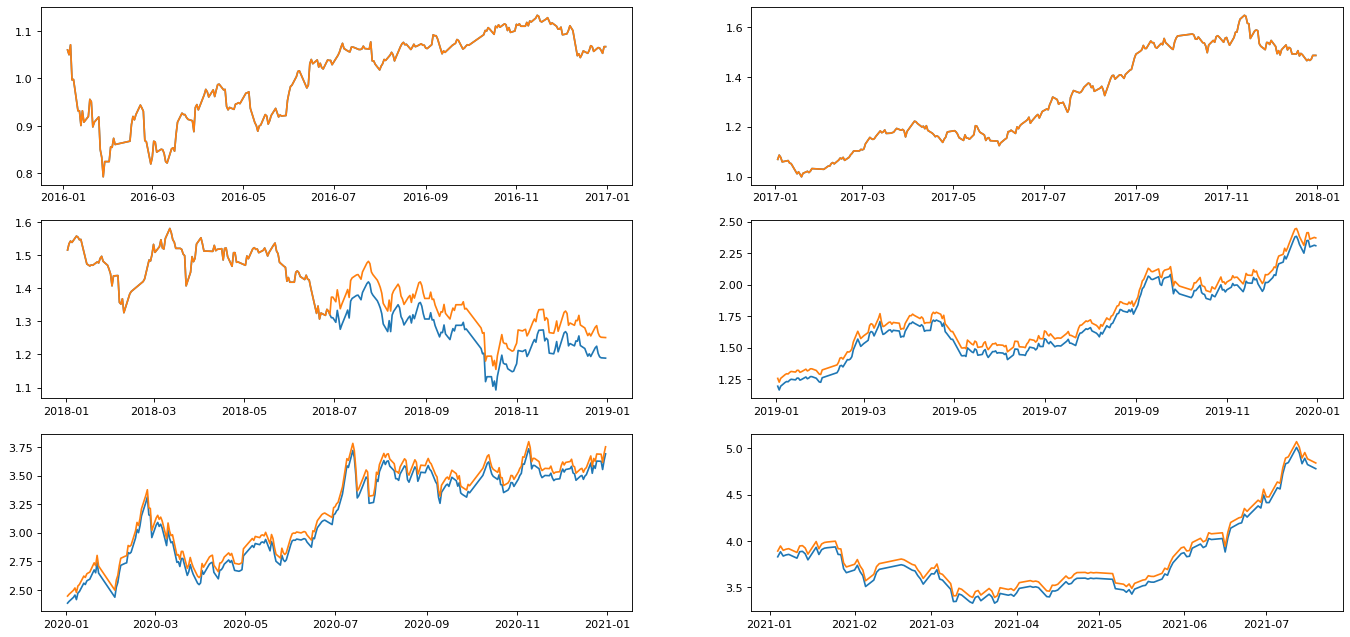

In [11]:
p = plt.figure(figsize=(21,10),dpi=80)
p.add_subplot(3,2,1)
plt.plot(dfsort['2016'])
p.add_subplot(3,2,2)
plt.plot(dfsort['2017'])
p.add_subplot(3,2,3)
plt.plot(dfsort['2018'])
p.add_subplot(3,2,4)
plt.plot(dfsort['2019'])
p.add_subplot(3,2,5)
plt.plot(dfsort['2020'])
p.add_subplot(3,2,6)
plt.plot(dfsort['2021'])

**查看数据集的自相关图**

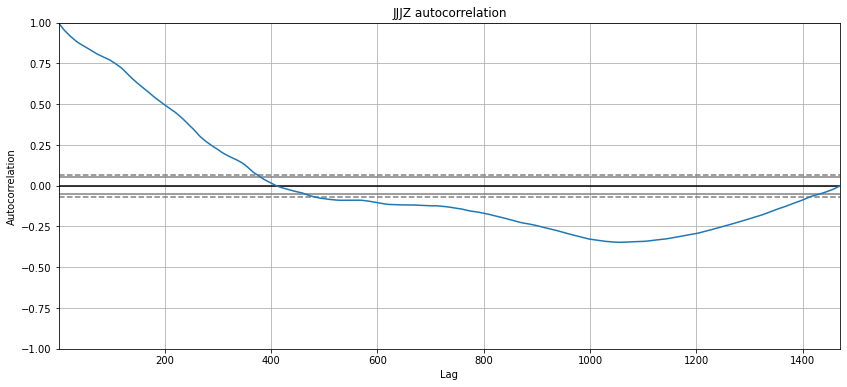

In [12]:
autocorrelation_plot(dfsort['JJJZ'])
plt.title('JJJZ autocorrelation')

plt.tick_params(labelsize=10)

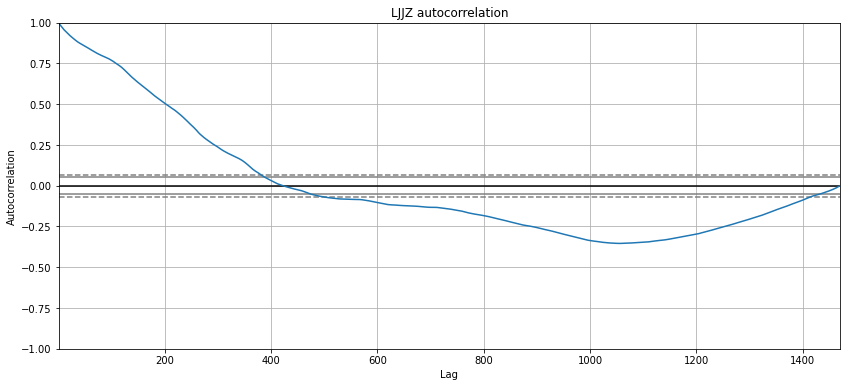

In [13]:
autocorrelation_plot(dfsort['LJJZ'])
plt.title('LJJZ autocorrelation')

plt.tick_params(labelsize=10)

横坐标为1000时， 就表示这个数据集所有数据与它之后1000天的数据的自相关程度。时间间隔的越远，自相关程度越低。

## 三、时间数据的特征工程
将单纯的日期维度扩展成更多维度，构造更多的输入给模型的特征，增强数据的可解释性。

In [14]:
dfDate = df

dfDate['Date'] = pd.to_datetime(dfDate['Date'])
# 构造新的一列： 年
dfDate.loc[:,'Year'] = dfDate['Date'].apply(lambda x:x.year)
# 构造新的一列： 月
dfDate.loc[:,'Month'] = dfDate['Date'].apply(lambda x:x.month)
# 构造新的一列： 星期几
dfDate.loc[:,'Weekday'] = dfDate['Date'].apply(lambda x:x.dayofweek)
# 构造新的一列： 一个月第几天
dfDate.loc[:,'Dom'] = dfDate['Date'].apply(lambda x:x.day)

# 添加上半月和下半月的信息
def half_month(day):
    if day in range(1,16):
        return 1
    else:
        return 2
dfDate.loc[:,'half_month'] = dfDate['Dom'].apply(lambda x:half_month(x))

# 添加每个月上中下旬的信息
def three_part_month(day):
    if day in range(1,11):
        return 1
    elif day in range(11,21):
        return 2
    else:
        return 3
dfDate.loc[:,'three_part_month'] = dfDate['Dom'].apply(lambda x:three_part_month(x))

# 添加每个月四个星期的信息  一个月的第几个星期
def four_week_month(day):
    if day in range(1, 8):
        return 1
    if day in range(8, 15):
        return 2
    if day in range(15, 22):
        return 3
    else:
        return 4
dfDate.loc[:, 'four_week_month'] = dfDate['Dom'].apply(lambda x: four_week_month(x))

dfDate = dfDate.sort_values(by='Date').set_index('Date')
dfDate

,JJJZ,LJJZ,Year,Month,Weekday,Dom,half_month,three_part_month,four_week_month
Date,,,,,,,,,
2015-10-28,1.031,1.031,2015,10,2,28,2,3,4
2015-10-29,1.038,1.038,2015,10,3,29,2,3,4
2015-10-30,1.042,1.042,2015,10,4,30,2,3,4
2015-11-02,1.030,1.030,2015,11,0,2,1,1,1
2015-11-03,1.025,1.025,2015,11,1,3,1,1,1
...,...,...,...,...,...,...,...,...,...
2021-07-13,4.953,5.015,2021,7,1,13,1,2,2
2021-07-14,4.835,4.897,2021,7,2,14,1,2,2
2021-07-15,4.894,4.956,2021,7,3,15,1,2,3


获取属性特征列表和目标值

In [15]:
columns = list(dfDate.columns.values)
columns_to_encoding = columns[2:]
y = dfDate['JJJZ']
x_before_dummy = dfDate[columns_to_encoding]
x_before_dummy

,Year,Month,Weekday,Dom,half_month,three_part_month,four_week_month
Date,,,,,,,
2015-10-28,2015,10,2,28,2,3,4
2015-10-29,2015,10,3,29,2,3,4
2015-10-30,2015,10,4,30,2,3,4
2015-11-02,2015,11,0,2,1,1,1
2015-11-03,2015,11,1,3,1,1,1
...,...,...,...,...,...,...,...
2021-07-13,2021,7,1,13,1,2,2
2021-07-14,2021,7,2,14,1,2,2
2021-07-15,2021,7,3,15,1,2,3


将特征属性转化为独热编码模式

In [16]:
x_dummy = pd.get_dummies(x_before_dummy,columns=columns_to_encoding)
x_dummy

,Year_2015,Year_2016,Year_2017,Year_2018,Year_2019,Year_2020,Year_2021,Month_1,Month_2,Month_3,...,Dom_31,half_month_1,half_month_2,three_part_month_1,three_part_month_2,three_part_month_3,four_week_month_1,four_week_month_2,four_week_month_3,four_week_month_4
Date,,,,,,,,,,,,,,,,,,,,,
2015-10-28,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
2015-10-29,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
2015-10-30,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
2015-11-02,1,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
2015-11-03,1,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-13,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,1,0,0,1,0,0
2021-07-14,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,1,0,0,1,0,0
2021-07-15,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,1,0


In [17]:
y

Date
2015-10-28    1.031
2015-10-29    1.038
2015-10-30    1.042
2015-11-02    1.030
2015-11-03    1.025
              ...  
2021-07-13    4.953
2021-07-14    4.835
2021-07-15    4.894
2021-07-16    4.826
2021-07-19    4.781
Name: JJJZ, Length: 1470, dtype: float64

目标值维度

In [18]:
y.shape

(1470,)

## 四、机器学习模型回归拟合
### 4.1、多元线性回归

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

划分测试集与训练集

In [20]:
x_train,x_test,y_train,y_test = train_test_split(x_dummy,y,test_size=0.2,random_state=1,shuffle=True)

训练多元线性回归模型

In [21]:
lr_reg = LinearRegression()
lr_reg.fit(x_dummy,y)
print('斜率（线性模型中各特征对应的系数）:', lr_reg.coef_)

斜率（线性模型中各特征对应的系数）: [-2.42581426e+11 -2.42581426e+11 -2.42581426e+11 -2.42581426e+11
 -2.42581426e+11 -2.42581426e+11 -2.42581426e+11  1.09548460e+12
  1.09548460e+12  1.09548460e+12  1.09548460e+12  1.09548460e+12
  1.09548460e+12  1.09548460e+12  1.09548460e+12  1.09548460e+12
  1.09548460e+12  1.09548460e+12  1.09548460e+12  7.30040099e+11
  7.30040099e+11  7.30040099e+11  7.30040099e+11  7.30040099e+11
  7.30040099e+11  7.30040099e+11  3.12429791e+12  3.12429791e+12
  3.12429791e+12  3.12429791e+12  3.12429791e+12  3.12429791e+12
  3.12429791e+12  1.53025691e+12  1.53025691e+12  1.53025691e+12
 -3.45299091e+12 -3.45299091e+12 -3.45299091e+12 -3.45299091e+12
 -1.24484565e+12  1.47051688e+12  1.47051688e+12  1.47051688e+12
  1.47051688e+12  1.47051688e+12  5.06779484e+12  3.49599549e+11
  3.49599549e+11  3.49599549e+11  3.49599549e+11  3.49599549e+11
  3.49599549e+11  3.49599549e+11  3.49599549e+11  3.49599549e+11
  3.49599549e+11  5.52793670e+12  2.81257417e+12 -2.90253194e+12
  2.08

预测值与真实值对比

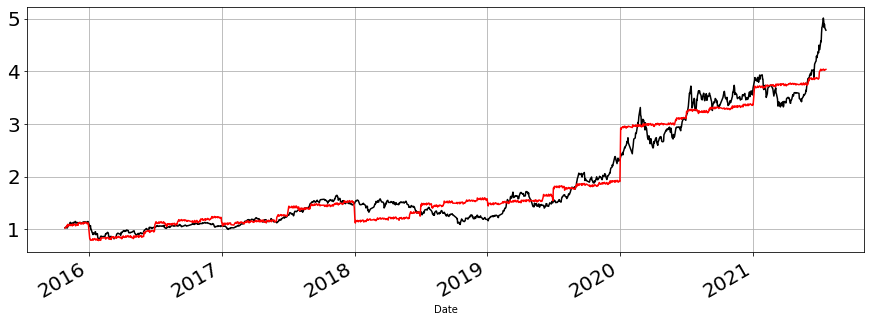

In [22]:
dfDate['JJJZ'].plot(style='k',figsize=(15,5))
dfDate.loc[:,'LinearRegression'] = lr_reg.predict(x_dummy)
plt.plot(dfDate['LinearRegression'],'r')

# 设置坐标文字大小
plt.tick_params(labelsize=20)

# 生成刻度线网格
plt.grid()

各年份预测值与真实值对比

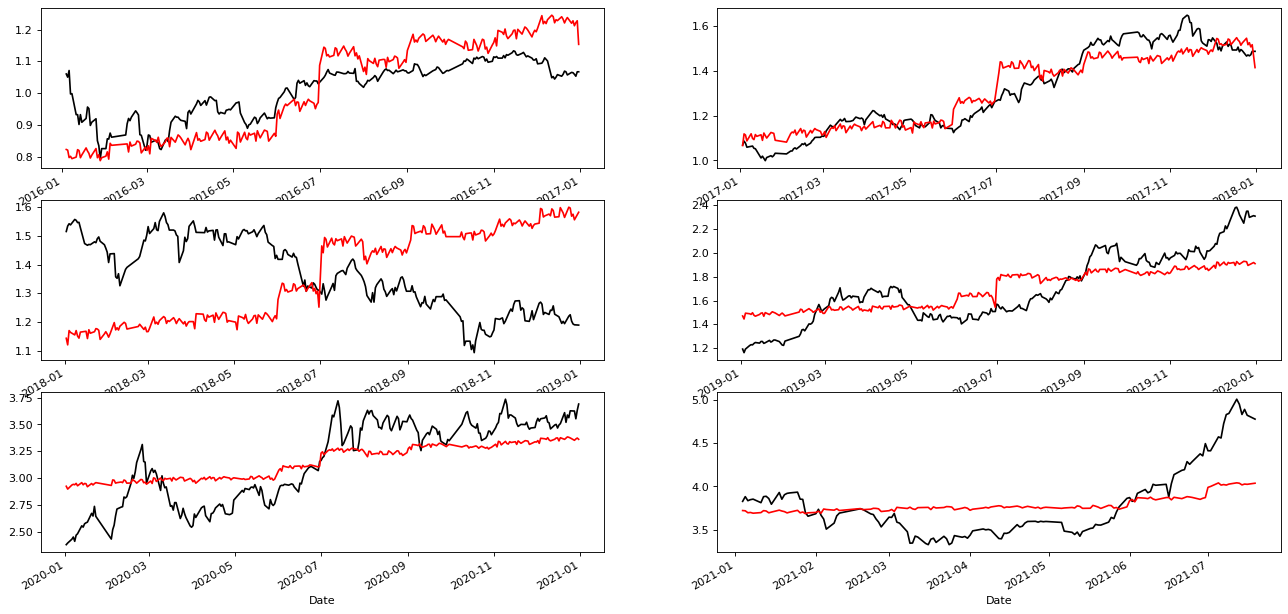

In [23]:
p = plt.figure(figsize=(21,10),dpi=80)
p.add_subplot(3,2,1)
dfDate['2016']['JJJZ'].plot(style='k',figsize=(20,10))
plt.plot(dfDate['2016']['LinearRegression'],'r')
p.add_subplot(3,2,2)
dfDate['2017']['JJJZ'].plot(style='k',figsize=(20,10))
plt.plot(dfDate['2017']['LinearRegression'],'r')
p.add_subplot(3,2,3)
dfDate['2018']['JJJZ'].plot(style='k',figsize=(20,10))
plt.plot(dfDate['2018']['LinearRegression'],'r')
p.add_subplot(3,2,4)
dfDate['2019']['JJJZ'].plot(style='k',figsize=(20,10))
plt.plot(dfDate['2019']['LinearRegression'],'r')
p.add_subplot(3,2,5)
dfDate['2020']['JJJZ'].plot(style='k',figsize=(20,10))
plt.plot(dfDate['2020']['LinearRegression'],'r')
p.add_subplot(3,2,6)
dfDate['2021']['JJJZ'].plot(style='k',figsize=(20,10))
plt.plot(dfDate['2021']['LinearRegression'],'r')

### 4.2、二项多项式回归

In [24]:
from sklearn.preprocessing import PolynomialFeatures

In [25]:
# 构建一个特征处理器poly_reg, 它能将输入特征变成二次的
poly_reg = PolynomialFeatures(degree=2)

# 使用构建的二项多项式特征处理器poly_reg处理训练数据dummy_X, 得到包含二次特征的训练集X_poly
X_poly = poly_reg.fit_transform(x_dummy)
X_poly_train = poly_reg.fit_transform(x_train)

构建二次多项式回归模型并训练模型

In [26]:
lin_reg_2 = LinearRegression()
lin_reg_2.fit(X_poly,y)
# 查看回归方程系数
print('每个维度对应的系数（斜率）：Cofficients: ', lin_reg_2.coef_)

# 查看回归方程截距
print('截距： intercept', lin_reg_2.intercept_)

每个维度对应的系数（斜率）：Cofficients:  [-1.24204562e+11 -1.13502789e+12  2.59499574e+11 ...  9.45301191e+10
  0.00000000e+00  5.34520525e+11]
截距： intercept 1676461241265.2117


In [27]:
dfDate.loc[:,'LinearRegression2'] = lin_reg_2.predict(X_poly)
dfDate

,JJJZ,LJJZ,Year,Month,Weekday,Dom,half_month,three_part_month,four_week_month,LinearRegression,LinearRegression2
Date,,,,,,,,,,,
2015-10-28,1.031,1.031,2015,10,2,28,2,3,4,1.024414,1.017090
2015-10-29,1.038,1.038,2015,10,3,29,2,3,4,1.034668,1.106445
2015-10-30,1.042,1.042,2015,10,4,30,2,3,4,1.039551,1.050293
2015-11-02,1.030,1.030,2015,11,0,2,1,1,1,1.067383,1.051758
2015-11-03,1.025,1.025,2015,11,1,3,1,1,1,1.044434,1.097900
...,...,...,...,...,...,...,...,...,...,...,...
2021-07-13,4.953,5.015,2021,7,1,13,1,2,2,4.037598,4.881836
2021-07-14,4.835,4.897,2021,7,2,14,1,2,2,4.018066,4.834229
2021-07-15,4.894,4.956,2021,7,3,15,1,2,3,4.027832,4.825928


二项多项式回归结果对比

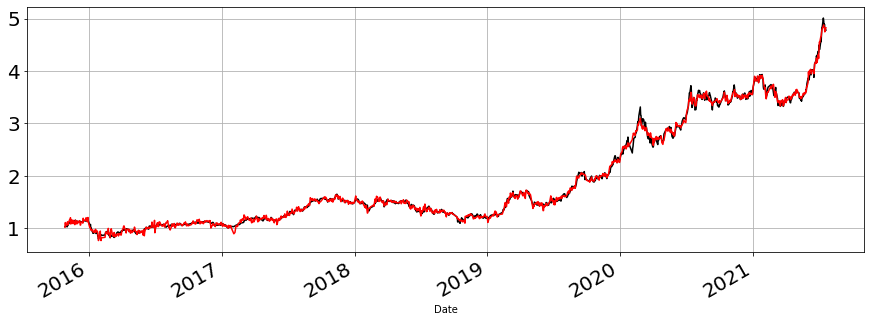

In [28]:
dfDate['JJJZ'].plot(style='k',figsize=(15,5))
plt.plot(dfDate['LinearRegression2'],'r')
# 设置坐标文字大小
plt.tick_params(labelsize=20)

# 生成刻度线网格
plt.grid()

各年份预测值与真实值对比

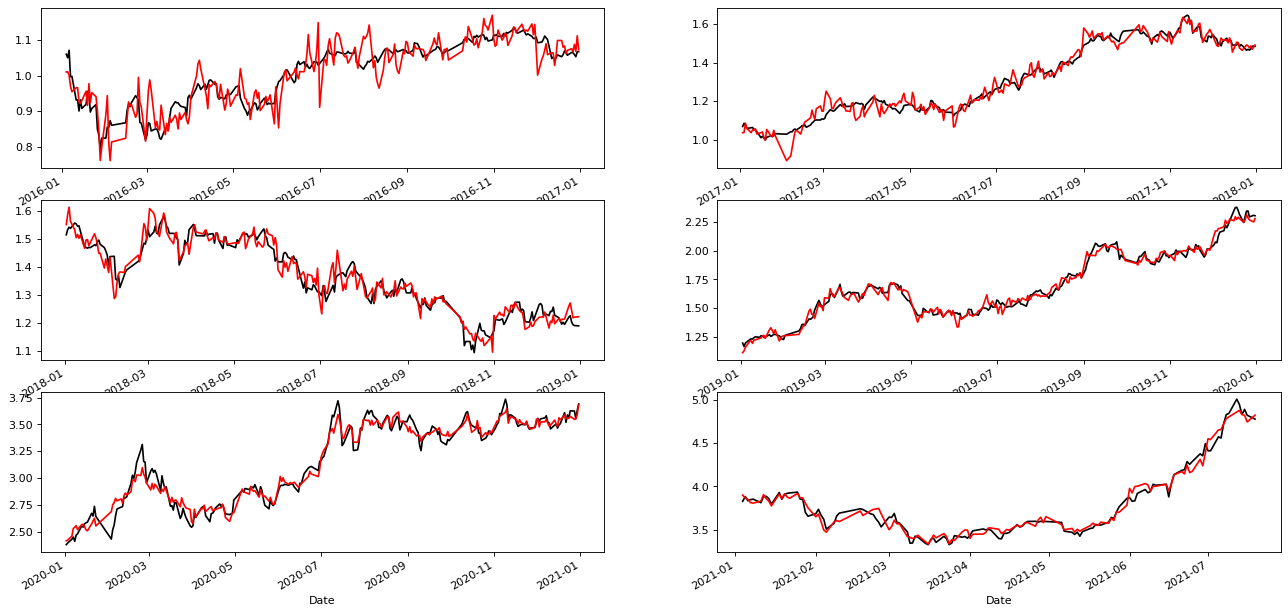

In [29]:
p = plt.figure(figsize=(21,10),dpi=80)
p.add_subplot(3,2,1)
dfDate['2016']['JJJZ'].plot(style='k',figsize=(20,10))
plt.plot(dfDate['2016']['LinearRegression2'],'r')
p.add_subplot(3,2,2)
dfDate['2017']['JJJZ'].plot(style='k',figsize=(20,10))
plt.plot(dfDate['2017']['LinearRegression2'],'r')
p.add_subplot(3,2,3)
dfDate['2018']['JJJZ'].plot(style='k',figsize=(20,10))
plt.plot(dfDate['2018']['LinearRegression2'],'r')
p.add_subplot(3,2,4)
dfDate['2019']['JJJZ'].plot(style='k',figsize=(20,10))
plt.plot(dfDate['2019']['LinearRegression2'],'r')
p.add_subplot(3,2,5)
dfDate['2020']['JJJZ'].plot(style='k',figsize=(20,10))
plt.plot(dfDate['2020']['LinearRegression2'],'r')
p.add_subplot(3,2,6)
dfDate['2021']['JJJZ'].plot(style='k',figsize=(20,10))
plt.plot(dfDate['2021']['LinearRegression2'],'r')

In [30]:
# pred_time = ['2021-06-18','2021-06-21','2021-06-22','2021-06-23','2021-06-24','2021-06-25']
# a = []
# for i in pred_time:
#     a.append(pd.to_datetime(i))
# dftp = pd.DataFrame({'Date':a})
# dftp.loc[:,'Year'] = dftp['Date'].apply(lambda x:x.year)

# dftp.loc[:,'Month'] = dftp['Date'].apply(lambda x:x.month)
# # 构造新的一列： 星期几
# dftp.loc[:,'Weekday'] = dftp['Date'].apply(lambda x:x.dayofweek)
# # 构造新的一列： 一个月第几天
# dftp.loc[:,'Dom'] = dftp['Date'].apply(lambda x:x.day)
# dftp.loc[:,'half_month'] = dftp['Dom'].apply(lambda x:half_month(x))
# dftp.loc[:,'three_part_month'] = dftp['Dom'].apply(lambda x:three_part_month(x))
# dftp.loc[:, 'four_week_month'] = dftp['Dom'].apply(lambda x: four_week_month(x))
# dftp = dftp.sort_values(by='Date').set_index('Date')
# dftp

### 4.3、决策树和随机森林
决策树和随机森林的训练数据不需要进行独热向量编码，所以可以直接使用x_before_dummy

In [31]:
x_before_dummy

,Year,Month,Weekday,Dom,half_month,three_part_month,four_week_month
Date,,,,,,,
2015-10-28,2015,10,2,28,2,3,4
2015-10-29,2015,10,3,29,2,3,4
2015-10-30,2015,10,4,30,2,3,4
2015-11-02,2015,11,0,2,1,1,1
2015-11-03,2015,11,1,3,1,1,1
...,...,...,...,...,...,...,...
2021-07-13,2021,7,1,13,1,2,2
2021-07-14,2021,7,2,14,1,2,2
2021-07-15,2021,7,3,15,1,2,3


**导入依赖，构造决策树参数**

In [32]:
# 从Python机器学习与数据挖掘工具库sklearn导入随机森林回归器
from sklearn.ensemble import RandomForestRegressor

# 导入网格搜索交叉验证，网格搜索可以让模型参数按我们给定的列表遍历，找到效果最好的模型
# 交叉验证可以充分评估模型的准确性
from sklearn.model_selection import GridSearchCV

# 构造参数字典
param_grid = {
    'n_estimators': [5, 10, 20, 50, 100, 200],    # 决策树的个数
    'max_depth': [3, 5, 7],   # 最大树身， 树太深会造成过拟合
    'max_features': [0.6, 0.7, 0.8, 1]  # 决策树划分时考虑的最大特征数
}

In [33]:
x_0_train, x_0_test, y_0_train, y_0_test = train_test_split(x_before_dummy, y, test_size=0.2, random_state=1, shuffle=True)

In [34]:
rf = RandomForestRegressor()

In [35]:
grid = GridSearchCV(rf,param_grid=param_grid,cv=3)
grid.fit(x_0_train,y_0_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [3, 5, 7],
                         'max_features': [0.6, 0.7, 0.8, 1],
                         'n_estimators': [5, 10, 20, 50, 100, 200]})

**选取最优参数对应的模型，查看效果最好的参数**

In [36]:
grid.best_params_

{'max_depth': 7, 'max_features': 0.8, 'n_estimators': 200}

**指定模型效果最好的参数对应的模型**

In [37]:
rf_reg = grid.best_estimator_
rf_reg

RandomForestRegressor(max_depth=7, max_features=0.8, n_estimators=200)

**可视化决策树**

In [38]:
from sklearn import tree
import pydotplus
from IPython.display import Image,display

从随机森立中选取一棵决策树进行可视化

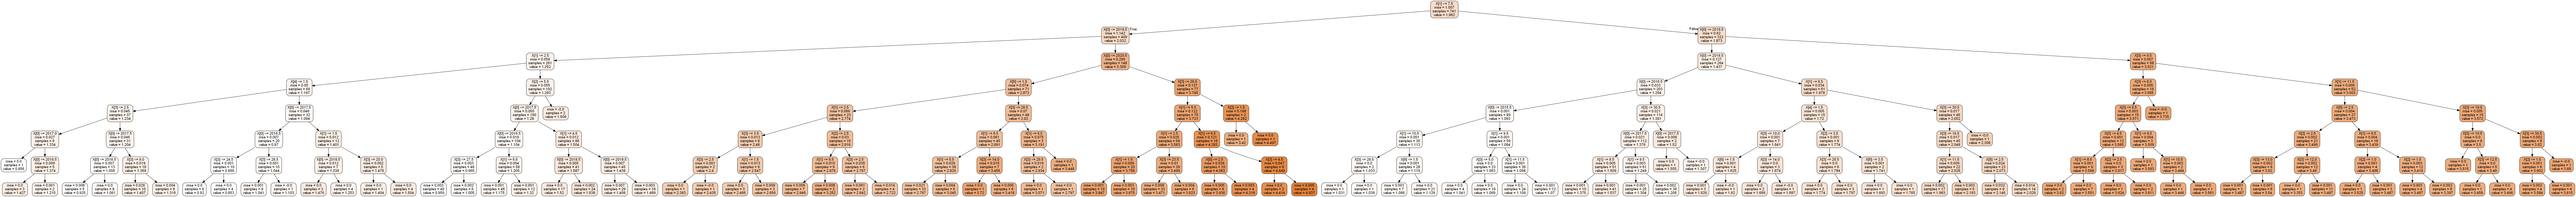

In [39]:
estimator = rf_reg.estimators_[5]
dot_data = tree.export_graphviz(estimator, out_file=None, filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)
display(Image(graph.create_png()))

**特征重要度分析**  
各特征重要度列表

In [40]:
rf_reg.feature_importances_

array([9.49385124e-01, 4.51663898e-02, 1.02994384e-03, 3.56497382e-03,
       1.22558213e-04, 2.90675881e-04, 4.40334495e-04])

特征重要度排序

In [41]:
print('特征排序')

feature_names = ['Year', 'Month', 'Weekday', 'Dom', 'half_month', 'three_part_month', 'four_week_month']

feature_importances = rf_reg.feature_importances_
indics = np.argsort(feature_importances)[::-1]

for index in indics:
    print('features %s (%f)' %(feature_names[index], feature_importances[index]))

特征排序
features Year (0.949385)
features Month (0.045166)
features Dom (0.003565)
features Weekday (0.001030)
features four_week_month (0.000440)
features three_part_month (0.000291)
features half_month (0.000123)


**特征重要度可视化**

([<matplotlib.axis.XTick at 0x1cd74e27438>,
 [Text(0, 0, 'Year'),
  Text(1, 0, 'Month'),
  Text(2, 0, 'Dom'),
  Text(3, 0, 'Weekday'),
  Text(4, 0, 'four_week_month'),
  Text(5, 0, 'three_part_month'),
  Text(6, 0, 'half_month')])

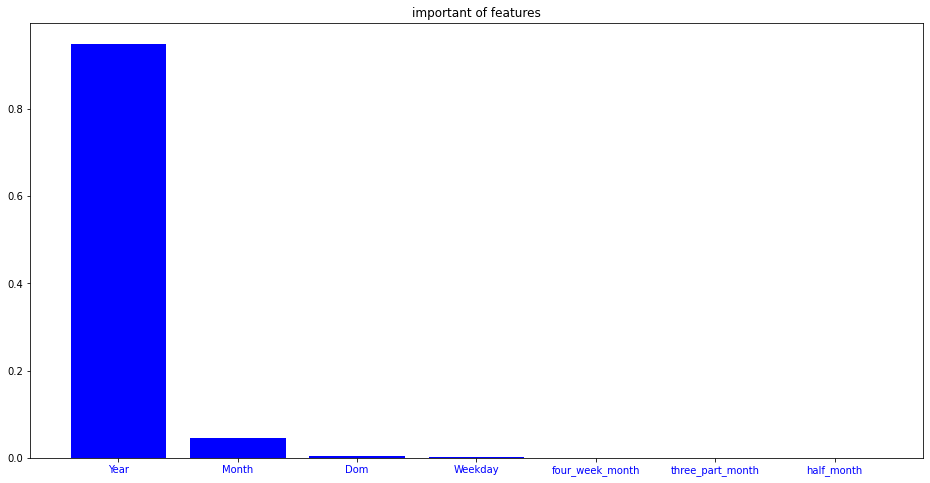

In [42]:
plt.figure(figsize=(16, 8))

plt.title('important of features')
plt.bar(range(len(feature_importances)), feature_importances[indics], color='b')
plt.xticks(range(len(feature_importances)), np.array(feature_names)[indics], color='b')

**可视化回归拟合效果**

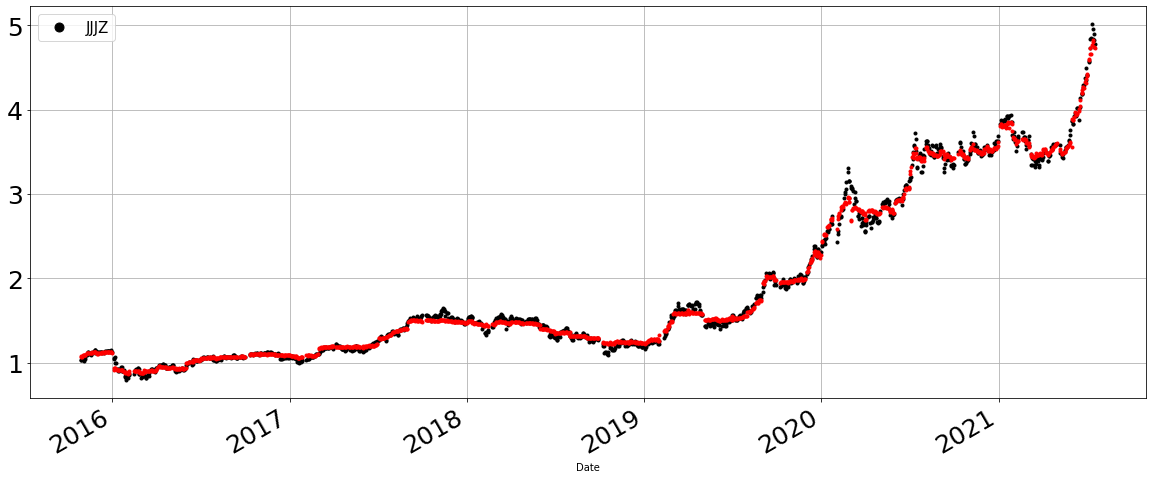

In [43]:
dfDate['JJJZ'].plot(style='k.', figsize=(20, 8))

dfDate.loc[:, 'randomForest'] = rf_reg.predict(x_before_dummy)
plt.plot(dfDate['randomForest'], 'r.')

plt.legend(fontsize=15, markerscale=3)

plt.tick_params(labelsize=25)

plt.grid()

In [44]:
dfDate

,JJJZ,LJJZ,Year,Month,Weekday,Dom,half_month,three_part_month,four_week_month,LinearRegression,LinearRegression2,randomForest
Date,,,,,,,,,,,,
2015-10-28,1.031,1.031,2015,10,2,28,2,3,4,1.024414,1.017090,1.076263
2015-10-29,1.038,1.038,2015,10,3,29,2,3,4,1.034668,1.106445,1.068552
2015-10-30,1.042,1.042,2015,10,4,30,2,3,4,1.039551,1.050293,1.074208
2015-11-02,1.030,1.030,2015,11,0,2,1,1,1,1.067383,1.051758,1.088190
2015-11-03,1.025,1.025,2015,11,1,3,1,1,1,1.044434,1.097900,1.090028
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-13,4.953,5.015,2021,7,1,13,1,2,2,4.037598,4.881836,4.831149
2021-07-14,4.835,4.897,2021,7,2,14,1,2,2,4.018066,4.834229,4.802086
2021-07-15,4.894,4.956,2021,7,3,15,1,2,3,4.027832,4.825928,4.743845


### 4.4、深层神经网络
神经网络对输入特征的幅度很敏感，我们首先需要将输入特征归一化

In [45]:
from sklearn.preprocessing import scale

# 使用Keras模型快速搭建全连接神经网络
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.optimizers import SGD

warnings.filterwarnings('ignore')

Using TensorFlow backend.


划分训练集和测试集

In [46]:
feature = scale(x_before_dummy)
x_1_train,x_1_val,y_1_train,y_1_val = train_test_split(feature,y,test_size=0.2,random_state=1,shuffle=True)

建立神经网络模型

In [47]:
model = Sequential()

# 第一层，32个神经元，激活函数是relu， 接收11个特征作为输入
model.add(Dense(128, activation='relu', input_shape=(x_1_train.shape[1], )))

# 第二层，64个神经元，激活函数为relu
model.add(Dense(196, activation='relu'))

# 回归模型的神经网络最后一层不需要有激活函数，直接用一个神经元线性输出结果即可
model.add(Dense(1))

# 将模型封装好，使用均方误差mse作为损失函数，使用学习率0.001的随机梯度下降算法反向传播，同时平均绝对误差mae监控模型训练效果
model.compile(loss='mse', optimizer=SGD(lr=0.001), metrics=['mae'])

**产看模型结构**

In [48]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 196)               25284     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 197       
Total params: 26,505
Trainable params: 26,505
Non-trainable params: 0
_________________________________________________________________


**训练神经网络, 每一批128个数据， 训练100轮， 每一轮结束后用验证集评估模型效果**

In [49]:
network_history = model.fit(x_1_train, y_1_train, batch_size=128, epochs=250, verbose=1, validation_data=(x_1_val, y_1_val))

Train on 1176 samples, validate on 294 samples
Epoch 1/250
1176/1176 [==============================] - 0s - loss: 3.6027 - mean_absolute_error: 1.6244 - val_loss: 3.0507 - val_mean_absolute_error: 1.4691
Epoch 2/250
1176/1176 [==============================] - 0s - loss: 3.0381 - mean_absolute_error: 1.4458 - val_loss: 2.5787 - val_mean_absolute_error: 1.3027
Epoch 3/250
1176/1176 [==============================] - 0s - loss: 2.5861 - mean_absolute_error: 1.2839 - val_loss: 2.1991 - val_mean_absolute_error: 1.1530
Epoch 4/250
1176/1176 [==============================] - 0s - loss: 2.2216 - mean_absolute_error: 1.1390 - val_loss: 1.8910 - val_mean_absolute_error: 1.0224
Epoch 5/250
1176/1176 [==============================] - 0s - loss: 1.9248 - mean_absolute_error: 1.0145 - val_loss: 1.6355 - val_mean_absolute_error: 0.9108
Epoch 6/250
1176/1176 [==============================] - 0s - loss: 1.6772 - mean_absolute_error: 0.9132 - val_loss: 1.4325 - val_mean_absolute_error: 0.8281
Epoch

**绘制训练过程的均方根误差mse和绝对平均误差mae**

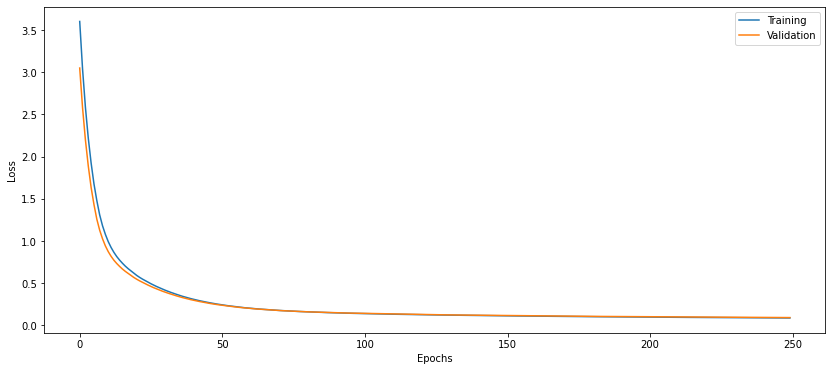

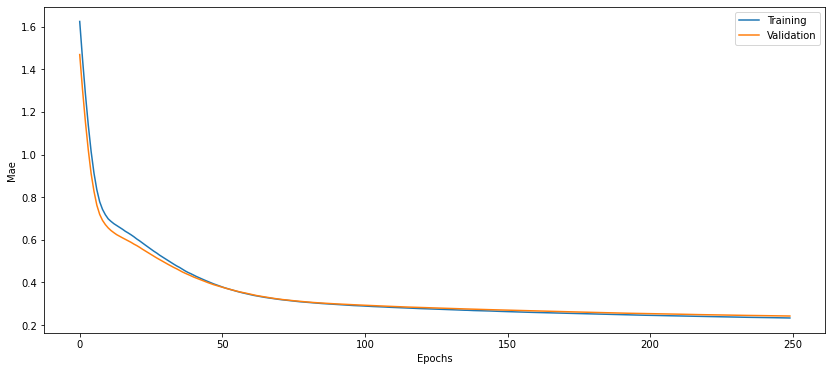

In [50]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])
    
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Mae')
    plt.plot(network_history.history['mean_absolute_error'])
    plt.plot(network_history.history['val_mean_absolute_error'])
    plt.legend(['Training', 'Validation'])
    plt.show()

plot_history(network_history)

In [51]:
model.evaluate(x_1_val, y_1_val, batch_size=10)

 10/294 [>.............................] - ETA: 0s

[0.09263819466237308, 0.24238631970622912]

查看模型预测值

In [52]:
dfDate.loc[:, "NetWork"] = model.predict(scale(x_before_dummy))

绘出模型预测与真实值对比图

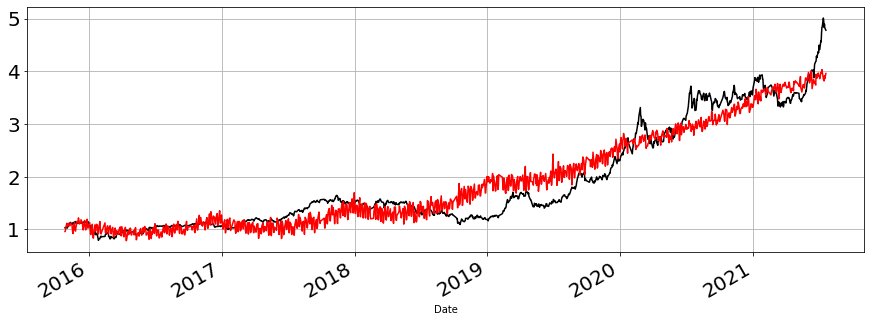

In [53]:
dfDate['JJJZ'].plot(style='k',figsize=(15,5))
plt.plot(dfDate['NetWork'],'r')

# 设置坐标文字大小
plt.tick_params(labelsize=20)

# 生成刻度线网格
plt.grid()

### 4.5、LSTM模型预测基金趋势

导入LSTM所需依赖

In [54]:
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
import copy

查看数据并划分训练集和测试集，将2020-09-01之前的数据作为训练集，之后的数据作为测试集。

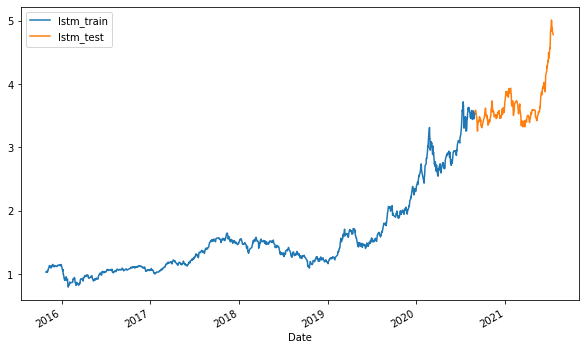

In [55]:
split_date = pd.Timestamp('2020-09-01')
df_data = dfDate['JJJZ']
lstm_train = df_data.loc[:split_date]
lstm_test = df_data.loc[split_date:]
lstm_all = copy.deepcopy(df_data)
plt.figure(figsize=(10,6))
ax = lstm_train.plot()
lstm_test.plot(ax=ax)
plt.legend(['lstm_train','lstm_test'])

In [56]:
lstm_train

Date
2015-10-28    1.031
2015-10-29    1.038
2015-10-30    1.042
2015-11-02    1.030
2015-11-03    1.025
              ...  
2020-08-26    3.450
2020-08-27    3.483
2020-08-28    3.529
2020-08-31    3.525
2020-09-01    3.560
Name: JJJZ, Length: 1248, dtype: float64

曲线没啥规律，有急剧增长的，也有急剧下降的，毫无规律可言。  
对数据进行归一化。

In [57]:
scaler = MinMaxScaler(feature_range=(-1,1))
print(lstm_train.values.reshape(-1,1).shape)
lstm_train_sc = scaler.fit_transform(lstm_train.values.reshape(-1,1))
lstm_test_sc = scaler.transform(lstm_test.values.reshape(-1,1))
lstm_all_sc = scaler.transform(lstm_all.values.reshape(-1,1))

(1248, 1)


以**前两天**数据为间隔，预测第三天数据。

In [58]:
def create_dataset(dataset, look_back):
#这里的look_back与timestep相同
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX),np.array(dataY)

In [59]:
look_back = 2
lstm_X_train,lstm_y_train  = create_dataset(lstm_train_sc,look_back)
lstm_X_test,lstm_y_test = create_dataset(lstm_test_sc,look_back)
lstm_X_all,lstm_y_all = create_dataset(lstm_all_sc,look_back)

建立LSTM模型进行训练。

In [60]:
lstm_model = Sequential()
lstm_model.add(LSTM(7,input_shape=(2,lstm_X_train.shape[2]),activation='relu',kernel_initializer='lecun_uniform',return_sequences=False))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
early_stop = EarlyStopping(monitor='loss',patience=2,verbose=1)
# history_lstm_model = lstm_model.fit(lstm_X_train,lstm_y_train,epochs=300,batch_size=1,verbose=1,shuffle=False)
history_lstm_model = lstm_model.fit(lstm_X_train,lstm_y_train,epochs=300,batch_size=1,verbose=1,shuffle=False,callbacks=[early_stop])

Epoch 1/300
1245/1245 [==============================] - 4s - loss: 0.0557     
Epoch 2/300
1245/1245 [==============================] - 3s - loss: 0.0031     
Epoch 3/300
1245/1245 [==============================] - 4s - loss: 0.0015     
Epoch 4/300
1245/1245 [==============================] - 4s - loss: 0.0011       
Epoch 5/300
1245/1245 [==============================] - 4s - loss: 9.0224e-04     
Epoch 6/300
1245/1245 [==============================] - 3s - loss: 8.4858e-04     
Epoch 7/300
1245/1245 [==============================] - 3s - loss: 8.1687e-04     
Epoch 8/300
1245/1245 [==============================] - 3s - loss: 8.0359e-04     
Epoch 9/300
1245/1245 [==============================] - 4s - loss: 7.8848e-04     
Epoch 10/300
1245/1245 [==============================] - 3s - loss: 7.7552e-04     
Epoch 11/300
1245/1245 [==============================] - 3s - loss: 7.5905e-04     
Epoch 12/300
1245/1245 [==============================] - 3s - loss: 7.2799e-04     
Epo

**对测试集进行模型评估。**

In [61]:
y_pred_test_lstm = lstm_model.predict(lstm_X_test)
y_pred_train_lstm = lstm_model.predict(lstm_X_train)
y_pred_all_lstm = lstm_model.predict(lstm_X_all)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(lstm_y_train, y_pred_train_lstm)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(lstm_y_test, y_pred_test_lstm)))

The R2 score on the Train set is:	0.977
The R2 score on the Test set is:	0.787


**绘出模型预测值与真实值对比图**

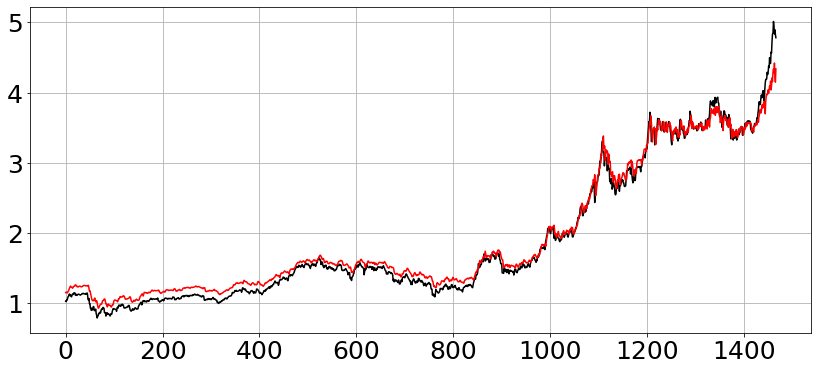

In [62]:
plt.plot(dfDate['JJJZ'][3:].values,'black')
plt.plot(scaler.inverse_transform(y_pred_all_lstm),'r')
# plt.legend(fontsize=15,markerscale=3)
plt.tick_params(labelsize=25)
plt.grid()

In [63]:
x_data_1=lstm_test[-2:]
print(x_data_1)
x_data_pre=scaler.transform(x_data_1.values.reshape(-1,1)).reshape(1,2,1)
result_pre=lstm_model.predict(x_data_pre)
print(scaler.inverse_transform(result_pre))

Date
2021-07-16    4.826
2021-07-19    4.781
Name: JJJZ, dtype: float64
[[4.2079053]]
